In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import sys
from pathlib import Path

# Ensure src is in the Python path
try:
    ROOT = Path(__file__).resolve().parent.parent
except NameError:
    ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

from src.config import DATA_RAW, DATA_PROCESSED, OUTPUT_PLOTS, FEATURE_COLUMNS
from src.data_loader import load_all_csv
from src.preprocessing import preprocess
from src.tags import tag_events, tag_frequencies
from src.anomaly_detection import detect_anomalies, tag_anomalies
from src.plotting import plot_time_with_events, plot_tag_anomalies, plot_time_with_unplugged_events, plot_time_with_state_bands, plot_time_with_tag_markers, plot_anomalies
pd.set_option("display.max_columns", None)

# Load Data/data_loader

In [19]:
df = load_all_csv()
df.head()

Combined data saved to ..\data\processed\merged_all_raw_data.csv


,date,time,ion_analog,voltage_ion,pressure_ion,conv_analog,voltage_conv,pressure_conv,tags
0,2025-06-23,14:06:02,444.0,2.19,2.440000e-07,193.0,0.954,0.00101,"IG on, CG on"
1,2025-06-23,14:06:03,445.0,2.20,2.500000e-07,194.0,0.959,0.00103,"IG on, CG on"
2,2025-06-23,14:06:04,444.0,2.19,2.440000e-07,194.0,0.959,0.00103,"IG on, CG on"
3,2025-06-23,14:06:05,445.0,2.20,2.500000e-07,194.0,0.959,0.00103,"IG on, CG on"
4,2025-06-23,14:06:06,444.0,2.19,2.440000e-07,193.0,0.954,0.00101,"IG on, CG on"


# Clean data/preprocessing

In [20]:
# drops unnecessary columns like analog and merges date and time to datetime column
df_cleaned_engineered = preprocess(df)
df_cleaned_engineered.head()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,tags,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll3_mean_ion,roll3_std_ion,roll3_min_ion,roll3_max_ion,roll15_mean_ion,roll15_std_ion,roll15_min_ion,roll15_max_ion,roll3_mean_conv,roll3_std_conv,roll3_min_conv,roll3_max_conv,roll15_mean_conv,roll15_std_conv,roll15_min_conv,roll15_max_conv,slope_ion,slope_conv
0,2025-06-23 14:06:02,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on",NaN,NaN,-15.226098,-6.897805,NaN,NaN,2.440000e-07,0.000000e+00,2.440000e-07,2.440000e-07,2.440000e-07,0.000000e+00,2.440000e-07,2.440000e-07,0.001010,0.000000,0.00101,0.00101,0.001010,0.000000,0.00101,0.00101,NaN,NaN
1,2025-06-23 14:06:03,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on",6.000000e-09,0.00002,-15.201805,-6.878196,0.024293,0.019608,2.470000e-07,3.000000e-09,2.440000e-07,2.500000e-07,2.470000e-07,3.000000e-09,2.440000e-07,2.500000e-07,0.001020,0.000010,0.00101,0.00103,0.001020,0.000010,0.00101,0.00103,NaN,NaN
2,2025-06-23 14:06:04,2.19,2.440000e-07,0.959,0.00103,"IG on, CG on",-6.000000e-09,0.00000,-15.226098,-6.878196,-0.024293,0.000000,2.460000e-07,2.828427e-09,2.440000e-07,2.500000e-07,2.460000e-07,2.828427e-09,2.440000e-07,2.500000e-07,0.001023,0.000009,0.00101,0.00103,0.001023,0.000009,0.00101,0.00103,NaN,NaN
3,2025-06-23 14:06:05,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on",6.000000e-09,0.00000,-15.201805,-6.878196,0.024293,0.000000,2.480000e-07,2.828427e-09,2.440000e-07,2.500000e-07,2.470000e-07,3.000000e-09,2.440000e-07,2.500000e-07,0.001030,0.000000,0.00103,0.00103,0.001025,0.000009,0.00101,0.00103,NaN,NaN
4,2025-06-23 14:06:06,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on",-6.000000e-09,-0.00002,-15.226098,-6.897805,-0.024293,-0.019608,2.460000e-07,2.828427e-09,2.440000e-07,2.500000e-07,2.464000e-07,2.939388e-09,2.440000e-07,2.500000e-07,0.001023,0.000009,0.00101,0.00103,0.001022,0.000010,0.00101,0.00103,0.0,0.0


In [21]:
df_cleaned_engineered.isnull().sum()
df_cleaned_engineered["IC_unplugged"]= df_cleaned_engineered[["voltage_ion", "pressure_ion"]].isna().all(axis=1)
df_cleaned_engineered["CC_unplugged"]= df_cleaned_engineered[["voltage_conv", "pressure_conv"]].isna().all(axis=1)

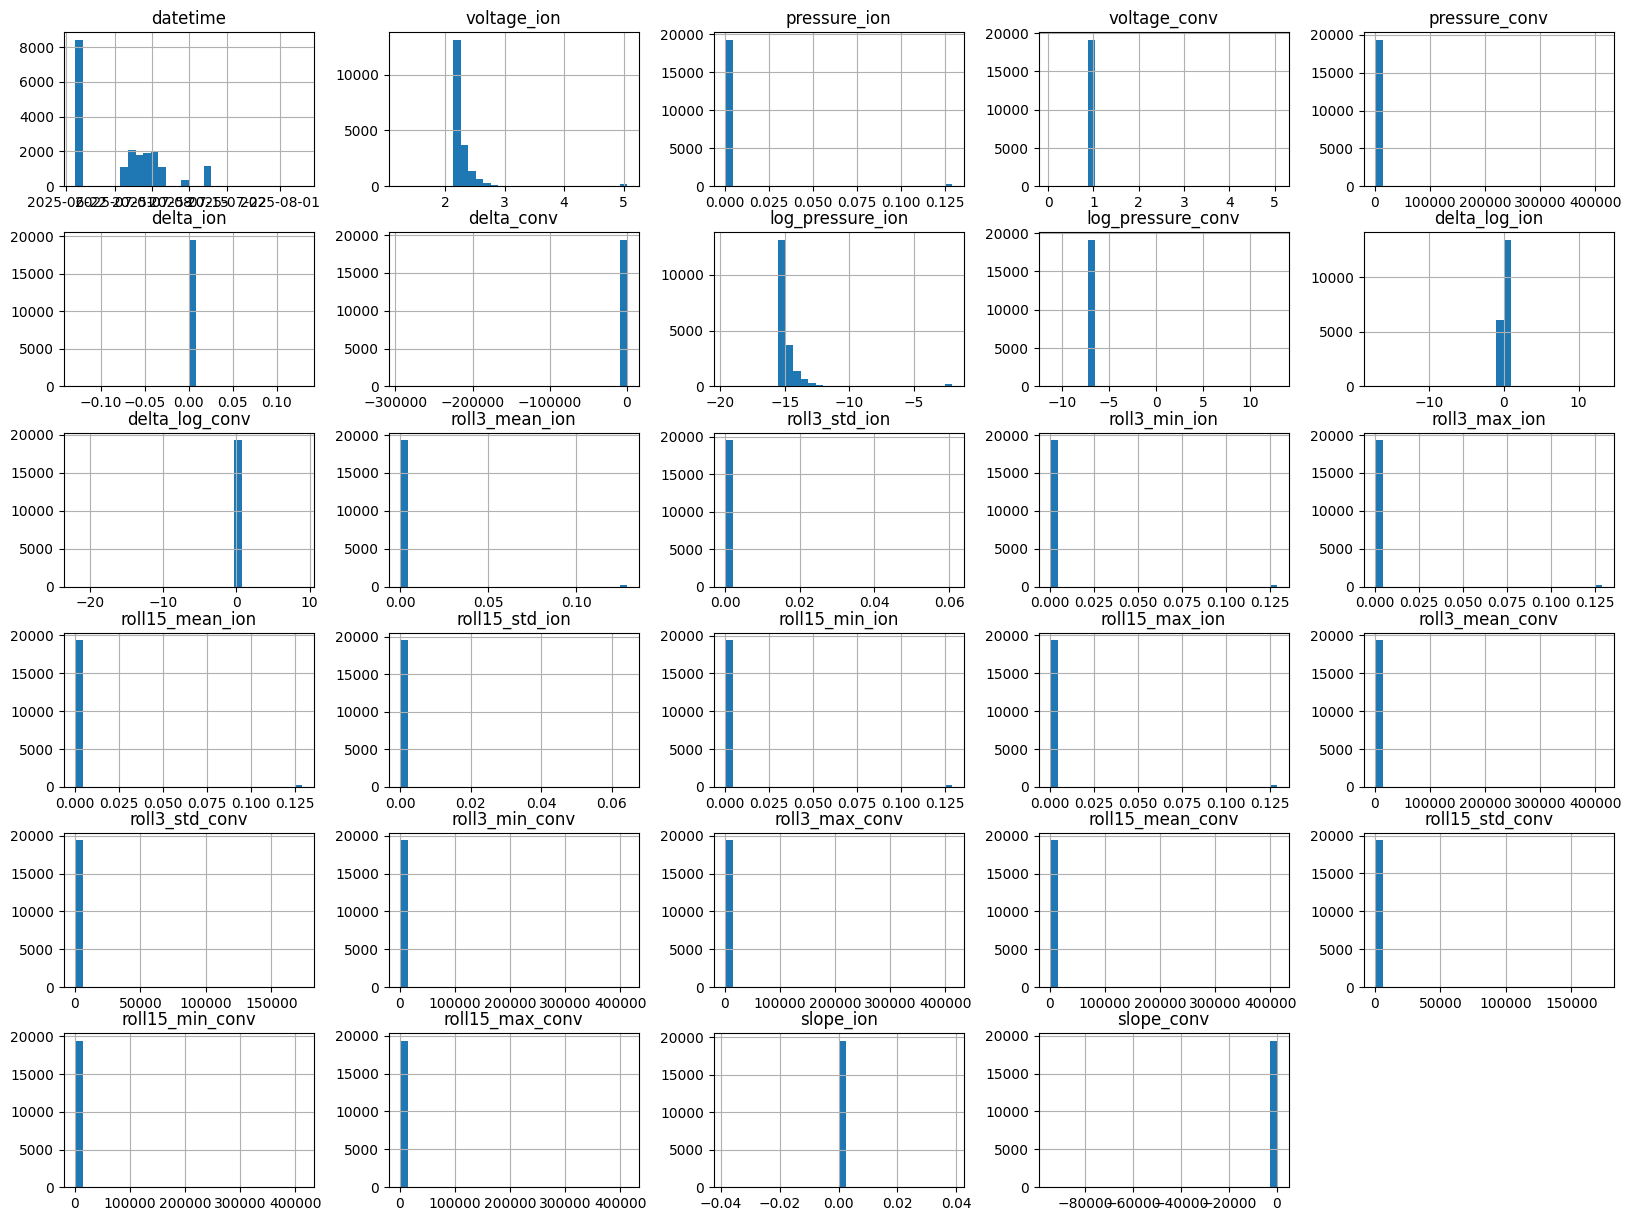

In [22]:
df_cleaned_engineered.hist(bins=30, figsize=(20,15))
plt.show()

<Axes: >

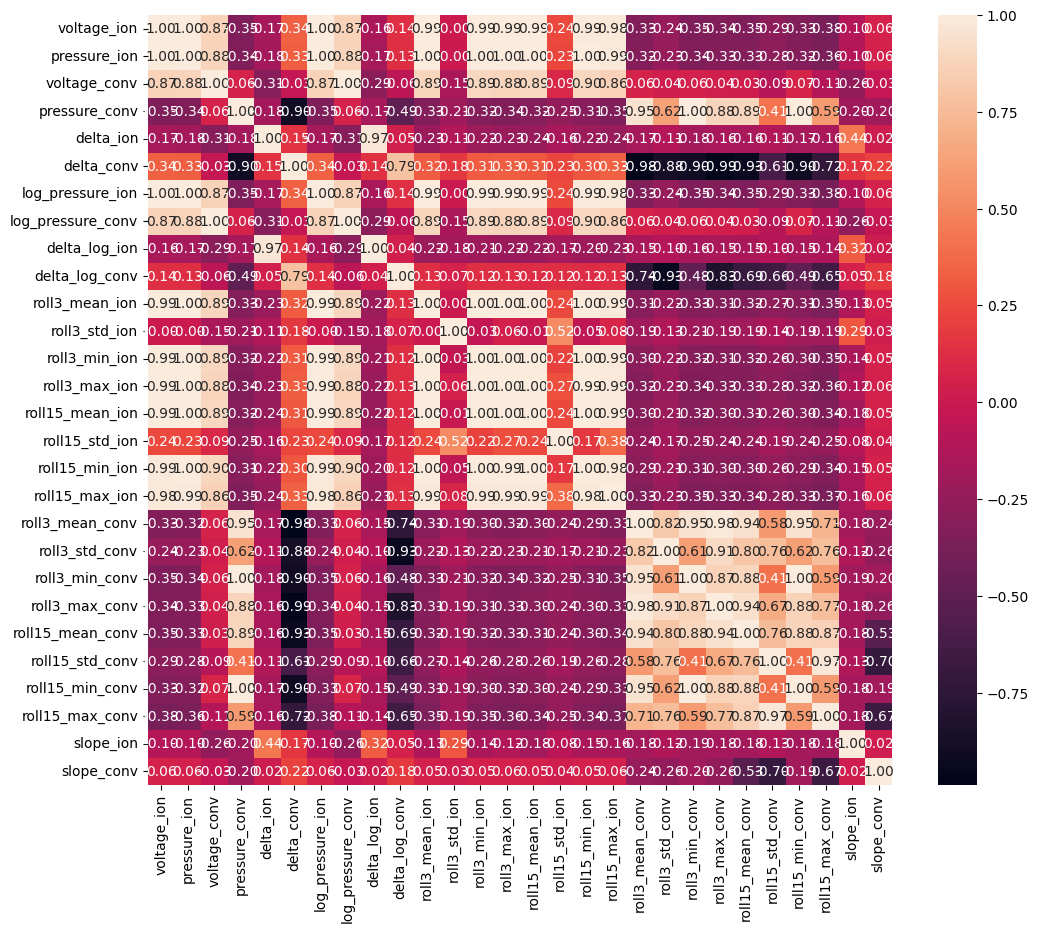

In [23]:
import seaborn as sns
df_heatmap = df_cleaned_engineered.select_dtypes(include='number').corr()
plt.figure(figsize=(12, 10))
sns.heatmap(df_heatmap.corr(), annot=True, fmt=".2f")

# Tags analysis

Create binary columns for key tag types

In [24]:
# Parse tags into list
#  Add binary columns for using MultiLabelBinarizer from sklearn
# Derive IG_state & CG_state

df_tags = tag_events(df_cleaned_engineered)

# Summary tag frequencies

In [25]:
# Tag frequencies
print("Tag Frequencies:\n", tag_frequencies(df_tags))

Tag Frequencies:
                   Tag  Count
0               CG on  19374
1               IG on  19276
2              IG off    719
3              CG off    658
4             venting    136
5               RP on    120
6   gate manipulation     64
7          IG turn on     27
8          IG slow on     18
9          CG turn on     12
10       chamber open     11
11        IG turn off     10
12        CG turn off      5
13            IG fail      5


# Detect anomalies

In [26]:
pd.set_option("display.max_columns", None)
df_altered = detect_anomalies(df_tags)
df_anomalies_ion = df_altered[df_altered["anomaly_if_ion"] == -1]
df_anomalies_conv = df_altered[df_altered["anomaly_if_conv"] == -1]
num_anomalies_ion = df_anomalies_ion.shape[0]
num_anomalies_conv = df_anomalies_conv.shape[0]
print(f"Number of Ion anomalies detected: {num_anomalies_ion}")
print(f"Number of Convectron anomalies detected: {num_anomalies_conv}")
num_anomalies = (df_altered["anomaly_if"] == -1).sum()
print(f"Number of anomalies detected: {num_anomalies}")

Number of Ion anomalies detected: 24
Number of Convectron anomalies detected: 201
Number of anomalies detected: 219


In [27]:
df_altered[df_altered['anomaly_if'] == -1].describe()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll3_mean_ion,roll3_std_ion,roll3_min_ion,roll3_max_ion,roll15_mean_ion,roll15_std_ion,roll15_min_ion,roll15_max_ion,roll3_mean_conv,roll3_std_conv,roll3_min_conv,roll3_max_conv,roll15_mean_conv,roll15_std_conv,roll15_min_conv,roll15_max_conv,slope_ion,slope_conv,tag_IG_on,tag_IG_off,tag_IG_fail,tag_IG_turn_on,tag_IG_turn_off,tag_IG_slow_on,tag_CG_on,tag_CG_off,tag_CG_turn_off,tag_CG_turn_on,tag_gate_manipulation,tag_RP_on,tag_chamber_open,tag_venting,anomaly_if_ion,score_if_raw_ion,score_if_ion,anomaly_if_conv,score_if_raw_conv,score_if_conv,anomaly_if,score_if_raw,score_if
count,219,214.00000,2.140000e+02,199.000000,199.000000,2.140000e+02,193.000000,214.000000,199.000000,214.000000,193.000000,2.170000e+02,217.000000,2.170000e+02,2.170000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,201.000000,201.000000,201.000000,201.000000,219.000000,219.000000,219.000000,219.000000,214.000000,177.000000,219.000000,219.000000,219.0,219.000000,219.000000,219.0,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.0,219.000000,219.000000
mean,2025-06-30 16:51:15.598173184,4.16243,8.801006e-02,2.955543,10952.842373,1.964047e-08,-8284.974009,-6.172898,2.781275,-0.014665,-0.582978,8.639700e-02,0.002242,8.441548e-02,8.917116e-02,8.234865e-02,4.601665e-03,7.657615e-02,8.894587e-02,17280.840503,7947.920036,9643.057821,26771.167099,24613.218130,26158.238860,8252.683204,80341.539572,0.000543,-2216.948980,0.296804,0.680365,0.0,0.013699,0.018265,0.0,0.853881,0.086758,0.004566,0.054795,0.013699,0.100457,0.050228,0.570776,0.780822,0.109343,-0.109343,-0.835616,-0.038101,0.038101,-1.0,-0.062026,0.062026
min,2025-06-23 14:29:52,1.30000,4.060000e-09,0.232000,0.000031,-1.290000e-01,-294000.000000,-19.322083,-10.391248,-17.274140,-22.103024,2.006667e-07,0.000000,4.060000e-09,2.040000e-07,1.631375e-07,0.000000e+00,3.020000e-09,2.040000e-07,0.000724,0.000000,0.000012,0.001010,0.000999,0.000000,0.000012,0.001010,-0.038698,-94799.999680,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.063597,-0.443575,-1.000000,-0.143389,-0.388712,-1.0,-0.143389,0.000387
25%,2025-06-23 15:49:16,2.19000,2.440000e-07,1.425000,0.009855,0.000000e+00,-21.000000,-15.226098,-4.619844,0.000000,-0.023896,2.460000e-07,0.000000,2.280000e-07,2.500000e-07,3.412667e-07,0.000000e+00,2.130000e-07,7.200000e-07,6.250370,0.003966,0.001110,9.710000,639.113333,11.474416,0.001010,978.000000,0.000000,-0.000550,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.271785,-1.000000,-0.084126,0.014642,-1.0,-0.084126,0.025647
50%,2025-06-23 16:25:16,5.06000,1.290000e-01,3.770000,827.000000,0.000000e+00,0.000000,-2.047943,6.717805,0.000000,0.000000,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,1.290000e-01,0.000000e+00,1.290000e-01,1.290000e-01,840.333333,10.842304,808.000000,868.000000,965.733333,69.656108,141.000000,978.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,-0.076035,0.076035,-1.0,-0.076035,0.076035
75%,2025-07-14 15:51:18.500000,5.06000,1.290000e-01,3.800000,955.000000,0.000000e+00,20.000000,-2.047943,6.861711,0.000000,0.023798,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,1.290000e-01,2.497219e-09,1.290000e-01,1.290000e-01,970.333333,14.522014,955.000000,978.000000,22718.182719,41641.325249,899.000000,119000.000000,0.000000,0.000698,1.000000,1.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.271785,-0.000000,-1.000000,-0.014642,0.084126,-1.0,-0.025647,0.084126
max,2025-07-20 07

## stats

In [28]:

print(df_altered[["pressure_ion","pressure_conv"]].describe())
print(df_altered["IG_state"].value_counts())

       pressure_ion  pressure_conv
count  1.957000e+04   19387.000000
mean   1.608804e-03     112.427689
std    1.431444e-02    5622.526377
min    3.020000e-09       0.000012
25%    2.280000e-07       0.001010
50%    2.440000e-07       0.001010
75%    3.760000e-07       0.001030
max    1.290000e-01  413000.000000
IG_state
IG on          19276
IG off           719
IG turn on        27
IG slow on        17
IG turn off        6
IG fail            2
Name: count, dtype: int64


# Plots

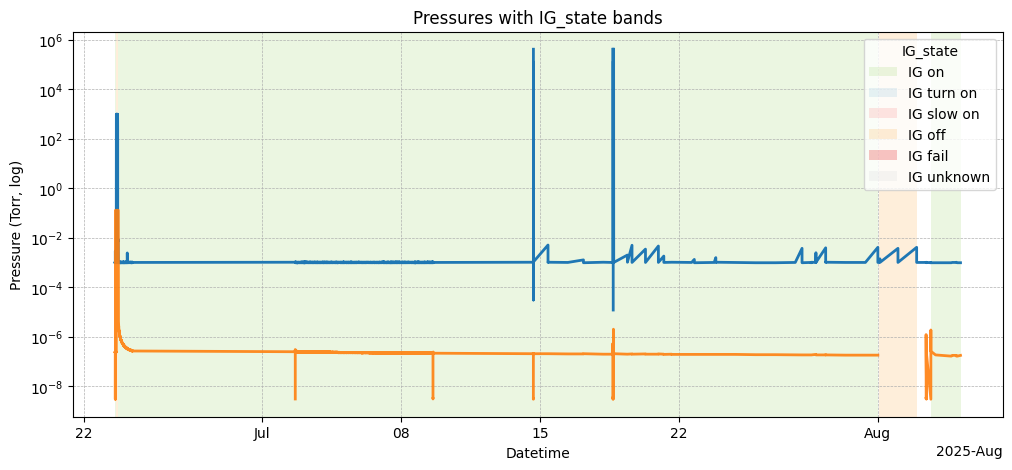

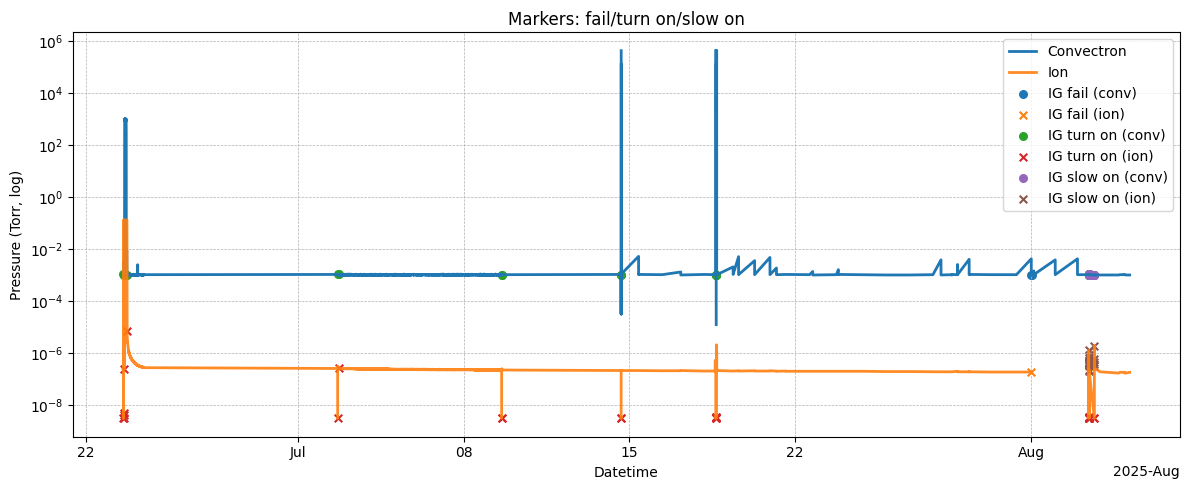

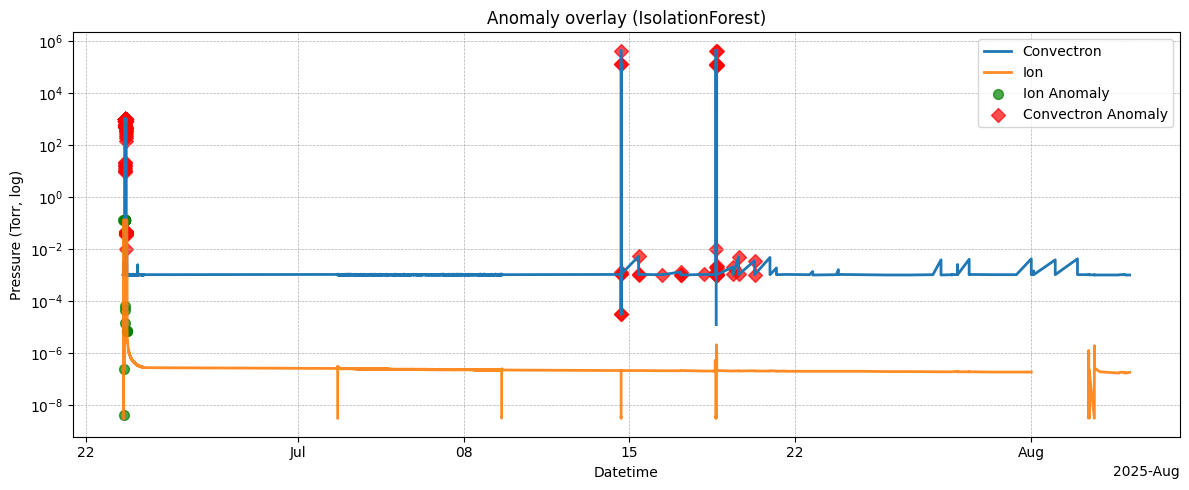

In [ ]:

plot_time_with_state_bands(df_altered.reset_index(), title="Pressures with IG_state bands")

plot_time_with_tag_markers(
    df_altered,
    tags_to_mark=("IG fail", "IG turn on", "IG slow on", "IG off"),
    title="Markers: fail/turn on/slow on",
    savepath=OUTPUT_PLOTS / "markers_fail_turnon_slowon_eng.png"
)

plot_anomalies(df_altered, title="Anomaly overlay (IsolationForest)", savepath=OUTPUT_PLOTS / "anomalies_overlay_eng.png")


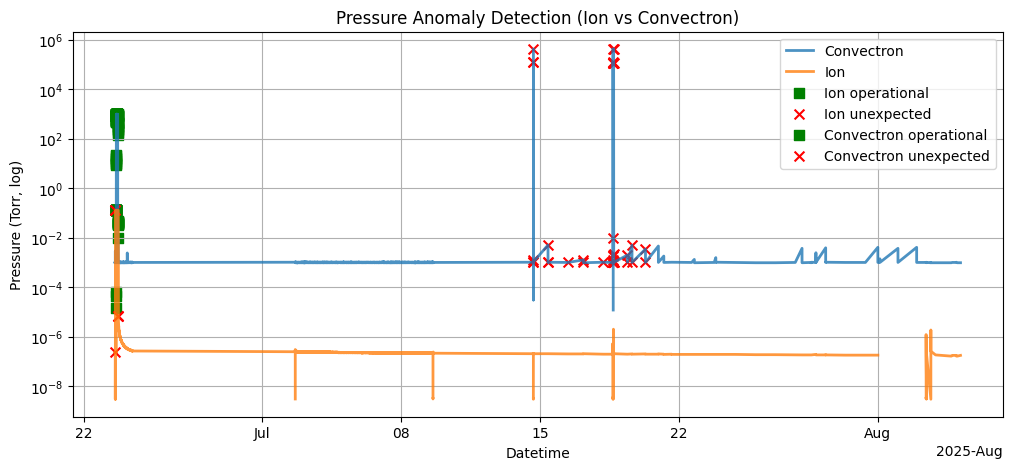

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,tags,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll3_mean_ion,roll3_std_ion,roll3_min_ion,roll3_max_ion,roll15_mean_ion,roll15_std_ion,roll15_min_ion,roll15_max_ion,roll3_mean_conv,roll3_std_conv,roll3_min_conv,roll3_max_conv,roll15_mean_conv,roll15_std_conv,roll15_min_conv,roll15_max_conv,slope_ion,slope_conv,IC_unplugged,CC_unplugged,tag_list,tag_IG_on,tag_IG_off,tag_IG_fail,tag_IG_turn_on,tag_IG_turn_off,tag_IG_slow_on,tag_CG_on,tag_CG_off,tag_CG_turn_off,tag_CG_turn_on,tag_gate_manipulation,tag_RP_on,tag_chamber_open,tag_venting,IG_state,CG_state,CH_state,anomaly_if_ion,score_if_raw_ion,score_if_ion,anomaly_if_conv,score_if_raw_conv,score_if_conv,anomaly_if,score_if_raw,score_if,has_op_tag,anomaly_ion,anomaly_conv
224,2025-06-23 15:37:49,5.06,0.129,2.84,9.04,"IG off, CG on, venting",0.0,9.03889,-2.047943,2.201659,0.0,9.005054,0.129,0.0,0.129,0.129,0.051609,0.063190,0.000002,0.129,3.014080,4.260969,0.00111,9.04,0.603667,2.254705,0.00103,9.04,0.0,1.807774,False,False,"[IG off, CG on, venting]",0,1,0,0,0,0,1,0,0,0,0,0,0,1,IG off,CG on,venting,-1,-0.018519,0.018519,-1,-0.020821,0.020821,-1,-0.020821,0.020821,True,operational,operational
225,2025-06-23 15:37:50,5.06,0.129,2.85,9.71,"IG off, CG on, venting",0.0,0.67000,-2.047943,2.273156,0.0,0.071497,0.129,0.0,0.129,0.129,0.060209,0.064348,0.000002,0.129,6.250370,4.427352,0.00111,9.71,1.250932,3.188869,0.00103,9.71,0.0,2.845665,False,False,"[IG off, CG on, venting]",0,1,0,0,0,0,1,0,0,0,0,0,0,1,IG off,CG on,venting,-1,-0.019373,0.019373,-1,-0.000306,0.000306,-1,-0.019373,0.019373,True,operational,operational
226,2025-06-23 15:37:51,5.06,0.129,2.87,10.40,"IG off, CG on, venting",0.0,0.69000,-2.047943,2.341806,0.0,0.068650,0.129,0.0,0.129,0.129,0.068809,0.064347,0.000002,0.129,9.716667,0.555238,9.04000,10.40,1.944197,3.894160,0.00103,10.40,0.0,3.050663,False,False,"[IG off, CG on, venting]",0,1,0,0,0,0,1,0,0,0,0,0,0,1,IG off,CG on,venting,-1,-0.021993,0.021993,-1,-0.001109,0.001109,-1,-0.021993,0.021993,True,operational,operational
229,2025-06-23 15:37:54,5.06,0.129,2.90,12.30,"IG off, CG on, venting",0.0,0.80000,-2.047943,2.509599,0.0,0.067252,0.129,0.0,0.129,0.129,0.094608,0.057032,0.000002,0.129,11.566667,0.573488,10.90000,12.30,4.257324,5.257652,0.00103,12.30,0.0,0.628000,False,False,"[IG off, CG on, venting]",0,1,0,0,0,0,1,0,0,0,0,0,0,1,IG off,CG on,venting,-1,-0.026434,0.026434,-1,-0.000261,0.000261,-1,-0.026434,0.026434,True,operational,operational
231,2025-06-23 15:37:56,5.06,0.129,2.94,14.90,"IG off, CG on, venting",0.0,2.00000,-2.047943,2.701361,0.0,0.144134,0.129,0.0,0.129,0.129,0.111807,0.043834,0.000043,0.129,13.366667,1.111555,12.30000,14.90,6.110517,5.858666,0.00108,14.90,0.0,0.940000,False,False,"[IG off, CG on, venting]",0,1,0,0,0,0,1,0,0,0,0,0,0,1,IG off,CG on,venting,-1,-0.029830,0.029830,-1,-0.002176,0.002176,-1,-0.029830,0.029830,True,operational,operational


In [30]:
df_plot = df_altered.reset_index()
df_plot = df_plot[(df_plot["datetime"] <= "2025-06-23 20:00:00") & (df_plot["datetime"] >= "2025-06-23 00:00:00")]
df_feat = tag_anomalies(df_altered)
plot_tag_anomalies(df_feat, title="Pressure Anomaly Detection (Ion vs Convectron)", savepath=OUTPUT_PLOTS / "pressure_anomaly_detection_eng.png")
table = df_feat[df_feat["anomaly_if_conv"] == -1]
table.head()

In [31]:
# filter for IG fail and anomaly
df_ig_fail = df_altered[
    (df_altered["anomaly_if"] == -1)
]

print(f"Number of IG fail events: {df_ig_fail.shape[0]}")




Number of IG fail events: 219


In [32]:
from sklearn.feature_selection import VarianceThreshold
# Only use columns that exist in df_altered
existing_features = [col for col in FEATURE_COLUMNS if col in df_altered.columns]
sel = VarianceThreshold(threshold=1e-6)
sel.fit(df_altered[existing_features])


VarianceThreshold(threshold=1e-06)

Total anomalies for each combination of slope window and contamination:
    0.005  0.010  0.020   0.050
3   129.0  234.0  468.0  1164.0
5   129.0  234.0  468.0  1164.0
7   129.0  234.0  468.0  1164.0
10  129.0  234.0  468.0  1164.0


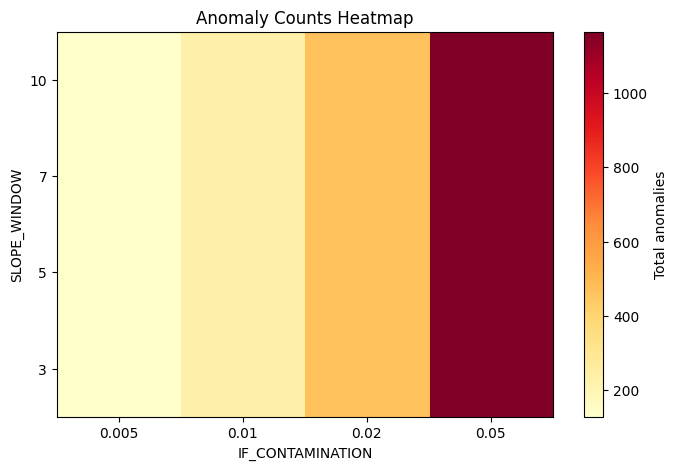

In [33]:
import numpy as np
df = pd.read_csv(  DATA_PROCESSED / "processed_edaALL.csv")
def detect_anomalies(df, slope_window=5, contamination=0.01):
    # Make a copy of df
    df = df.copy()
    
    # Dummy anomaly detection for demonstration
    # Replace this with your real detection logic
    np.random.seed(42)
    n = len(df)
    df["anomaly_ion"] = np.random.choice(["normal","operational","unexpected"], n, p=[1-contamination, contamination/2, contamination/2])
    df["anomaly_conv"] = np.random.choice(["normal","operational","unexpected"], n, p=[1-contamination, contamination/2, contamination/2])
    
    return df

# Define parameter ranges
slope_windows = [3, 5, 7, 10]
contaminations = [0.005, 0.01, 0.02, 0.05]

# Store results
results = pd.DataFrame(index=slope_windows, columns=contaminations)

# Run grid search
for slope in slope_windows:
    for cont in contaminations:
        df_tagged = detect_anomalies(df, slope_window=slope, contamination=cont)
        total_anomalies = ((df_tagged['anomaly_ion'] != "normal").sum() + 
                        (df_tagged['anomaly_conv'] != "normal").sum())
        results.loc[slope, cont] = total_anomalies

# Convert to numeric
results = results.astype(float)

# Print table
print("Total anomalies for each combination of slope window and contamination:")
print(results)

# Plot heatmap
plt.figure(figsize=(8,5))
plt.imshow(results, cmap="YlOrRd", origin="lower", aspect="auto")
plt.colorbar(label="Total anomalies")
plt.xticks(np.arange(len(contaminations)), contaminations)
plt.yticks(np.arange(len(slope_windows)), slope_windows)
plt.xlabel("IF_CONTAMINATION")
plt.ylabel("SLOPE_WINDOW")
plt.title("Anomaly Counts Heatmap")
plt.show()

In [34]:
out = DATA_PROCESSED / "processed_eng.csv"
df_altered.to_csv(out, index=False)
print(f"Saved combined data to {out}")

Saved combined data to ..\data\processed\processed_eng.csv
